In [110]:
# Block 1
# Imports


import tensorflow as tf
import numpy as np

import json
import glob
import os
import re
from tensorflow.keras.preprocessing.text import Tokenizer
import tokenize
from tensorflow.keras.preprocessing.sequence import pad_sequences

import tensorboard
import matplotlib.pyplot as plt

import datetime


base_log_dir = os.path.join("/workspace/logs", "run_" + datetime.datetime.now().strftime("%m_%d_%H_%M"))
fit_log_dir = os.path.join(base_log_dir, "fit")
loader_log_dir = os.path.join(base_log_dir, "loader")
debug_log_dir = os.path.join(base_log_dir, "debug")

"""
# Enable full debugging
#tf.config.optimizer.set_jit(False)  # Disable XLA compilation
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode() # Disables tf.data eager execution; not covered by run_functions_eagerly

tf.debugging.experimental.enable_dump_debug_info(
    debug_log_dir,
    tensor_debug_mode="NO_TENSOR", # CONCISE_HEALTH
    circular_buffer_size=1000) # 1000
"""


'\n# Enable full debugging\n#tf.config.optimizer.set_jit(False)  # Disable XLA compilation\ntf.config.run_functions_eagerly(True)\ntf.data.experimental.enable_debug_mode() # Disables tf.data eager execution; not covered by run_functions_eagerly\n\ntf.debugging.experimental.enable_dump_debug_info(\n    debug_log_dir,\n    tensor_debug_mode="NO_TENSOR", # CONCISE_HEALTH\n    circular_buffer_size=1000) # 1000\n'

In [111]:
# Block 2
# Loader


class Loader:
    def __init__(self, problems_path, submissions_dir, loader_log_dir, max_length_input, max_length_output, batch_size):
        self.problems_path = problems_path
        self.submissions_dir = submissions_dir
        self.max_length_input = max_length_input
        self.max_length_output = max_length_output
        self.batch_size = batch_size

        self.problem_tokenizer = Tokenizer(filters='')
        self.solution_tokenizer = Tokenizer(filters='', oov_token='UNK')
        self.dataset = None
        
        self.writer = tf.summary.create_file_writer(loader_log_dir)

    def _load_problems_and_solutions(self):
        # Load problems
        with open(self.problems_path, 'r') as problems_file:
            problems_list = json.load(problems_file)
        raw_problems = {}
        
        for problem in problems_list:
            problem_id = problem['problem_id']
            concatenated_problem = "XXSTATEMENT {} XXINPUT {} XXOUTPUT {} XXNOTES {} XXEXAMPLES {}".format(
                problem.get('problem_statement', ''),
                problem.get('problem_input', ''),
                problem.get('problem_output', ''),
                problem.get('problem_notes', ''),
                problem.get('examples', '')
            )
            raw_problems[problem_id] = concatenated_problem
            
        # Load solutions
        raw_solutions = [[] for _ in range(len(raw_problems) * 2)] # Estimate allows us to delete up to half
        submissions = glob.glob(os.path.join(self.submissions_dir, "*.py"))
        
        for submission_path in submissions:
            problem_number = int(re.findall(r'^\d+', os.path.basename(submission_path))[0])
            with open(submission_path, "r") as f:
                solutionList = []
                for token in tokenize.generate_tokens(f.readline):
                    solutionList.append(token.string)
                raw_solutions[problem_number].append(solutionList)
        
        # Combine problems and solutions
        problems = []
        solutions = []
        for problem_id, solution_set in enumerate(raw_solutions):
            if solution_set:
                for solution in solution_set:
                    problems.append(raw_problems[problem_id])
                    solutions.append(solution)

        return problems, solutions

    def tokenize_and_pad(self, problems, solutions):
        # Add SOS and EOS tokens
        decoder_inputs = [["XXSOS"] + s for s in solutions]
        targets = [s + ["XXEOS"] for s in solutions]
        
        # Fit Keras tokenizer
        self.problem_tokenizer.fit_on_texts(problems)
        self.solution_tokenizer.fit_on_texts(decoder_inputs + targets) # Both at once
        
        # Tokenize
        problems = self.problem_tokenizer.texts_to_sequences(problems)
        decoder_inputs = self.solution_tokenizer.texts_to_sequences(decoder_inputs)
        targets = self.solution_tokenizer.texts_to_sequences(targets)
        
        # Pad to same length
        problems = pad_sequences(problems, padding='post', maxlen=self.max_length_input)
        decoder_inputs = pad_sequences(decoder_inputs, padding='post', maxlen=self.max_length_output)
        targets = pad_sequences(targets, padding='post', maxlen=self.max_length_output)
        
        return problems, decoder_inputs, targets
    
    def log_vocabulary(self):
        with self.writer.as_default():
            for word, index in self.problem_tokenizer.word_index.items():
                tf.summary.text(name="Problem Vocabulary", data=f"{word}: {index}", step=0)

            for word, index in self.solution_tokenizer.word_index.items():
                tf.summary.text(name="Solution Vocabulary", data=f"{word}: {index}", step=0)

            self.writer.flush()
    
    def _create_tf_dataset(self, problems, decoder_inputs, targets):
        # Create the dataset
        dataset = tf.data.Dataset.from_tensor_slices(((problems, decoder_inputs), targets))
        
        return dataset.shuffle(buffer_size=1024).batch(self.batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    
    def _log_dataset_samples(self, problems, decoder_inputs, targets):
        with self.writer.as_default():
            for i, (problem, decoder_input, target) in enumerate(zip(problems, decoder_inputs, targets)):
                if i >= 5: # Log 5 samples
                    break
                
                # Convert padded sequences back to text
                problem_text = self.problem_tokenizer.sequences_to_texts([problem])
                decoder_input_text = self.solution_tokenizer.sequences_to_texts([decoder_input])
                target_text = self.solution_tokenizer.sequences_to_texts([target])

                # Truncate texts
                #max_display_length = 1024
                #problem_text = (problem_text[:max_display_length] + '...') if len(problem_text) > max_display_length else problem_text
                #solution_text = (solution_text[:max_display_length] + '...') if len(solution_text) > max_display_length else solution_text

                # Log to TensorBoard
                tf.summary.text(name=f"problem_{i}", data=problem_text, step=0)
                tf.summary.text(name=f"decoder_input_{i}", data=decoder_input_text, step=0)
                tf.summary.text(name=f"target_{i}", data=target_text, step=0)

            self.writer.flush()
            
    def load_data(self):
        problems, solutions = self._load_problems_and_solutions()

        problems, decoder_inputs, targets = self.tokenize_and_pad(problems, solutions)
        self._log_dataset_samples(problems, decoder_inputs, targets)
        self.dataset = self._create_tf_dataset(problems, decoder_inputs, targets)
        

In [112]:
# Block 3
# Positional Encoder

def positional_encoder(seq_length, dim):
    # Generate positions for each element
    positions = tf.range(seq_length, dtype=tf.float32)[..., tf.newaxis]

    # Create a range for the dimensions and compute division terms
    i = tf.range(dim, dtype=tf.float32)
    div_terms = 1 / tf.pow(10000.0, (2 * (i // 2)) / tf.cast(dim, tf.float32))

    # Calculate odd/even sinusoidal encodings
    angle_rates = positions * div_terms
    sine = tf.sin(angle_rates[:, 0::2])
    cosine = tf.cos(angle_rates[:, 1::2])

    # Interlace and reshape
    pos_encoding = tf.reshape(tf.concat([sine, cosine], axis=-1), [1, seq_length, dim])

    return pos_encoding


In [113]:
# Block 4
# Encoder/Decoder Layer classes


class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, dim, dim_ff, key_dim, num_heads, dropout_rate, name="EncoderLayer"):
        super(EncoderLayer, self).__init__(name=name)

        # Multi-Head Self-Attention layer
        self.mha = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)

        # Feed-Forward Network Layers
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(dim_ff, kernel_initializer='he_normal', name="encoder_ffn_dense1"), 
            tf.keras.layers.LeakyReLU(alpha=0.01), # Trying LeakyReLu
            tf.keras.layers.Dense(dim, kernel_initializer='he_normal', name="encoder_ffn_dense2")
        ], name="encoder_ffn")

        # Normalization Layers
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6, name="encoder_layernorm1")
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6, name="encoder_layernorm2")

        # Dropout
        self.dropout_mha = tf.keras.layers.Dropout(dropout_rate)
        self.dropout_ffn = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x, training=False):
        # Self-Attention
        attn_output = self.mha(x, x)
        attn_output = self.dropout_mha(attn_output, training=training) # Dropout
        out1 = self.layernorm1(x + attn_output)  # Residual connection

        # Feed-Forward Network
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout_ffn(ffn_output, training=training) # Dropout
        out2 = self.layernorm2(out1 + ffn_output)  # Residual connection

        return out2

    def get_config(self):
        config = super(EncoderLayer, self).get_config()
        mha_config = self.mha.get_config()
        config.update({
            "dim": self.ffn.layers[2].units, 
            "dim_ff": self.ffn.layers[0].units, 
            "num_heads": mha_config['num_heads'], 
            "key_dim": mha_config['key_dim'], 
            "dropout_rate": self.dropout_mha.rate
        })
        return config


class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, dim, dim_ff, key_dim, num_heads, dropout_rate, name="DecoderLayer"):
        super(DecoderLayer, self).__init__(name=name)

        # Self-Attention and Cross-Attention layers
        self.mha1 = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)
        self.mha2 = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)

        # Feed Forward Network Layers
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(dim_ff, kernel_initializer='he_normal', name="decoder_ffn_dense1"), 
            tf.keras.layers.LeakyReLU(alpha=0.01), # Trying LeakyReLu
            tf.keras.layers.Dense(dim, kernel_initializer='he_normal', name="decoder_ffn_dense2")
        ], name="decoder_ffn")

        # Normalization Layers
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6, name="decoder_layernorm1")
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6, name="decoder_layernorm2")
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6, name="decoder_layernorm3")

        # Dropout
        self.dropout_self_attn = tf.keras.layers.Dropout(dropout_rate)
        self.dropout_cross_attn = tf.keras.layers.Dropout(dropout_rate)
        self.dropout_ffn = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x, enc_output, training=False, look_ahead_mask=None, padding_mask=None):
        # Self-Attention
        attn1_output = self.mha1(x, x, attention_mask=look_ahead_mask)
        attn1_output = self.dropout_self_attn(attn1_output, training=training) # Dropout
        out1 = self.layernorm1(x + attn1_output)  # Residual connection

        # Cross-Attention
        attn2_output = self.mha2(out1, enc_output, attention_mask=padding_mask)
        attn2_output = self.dropout_cross_attn(attn2_output, training=training) # Dropout
        out2 = self.layernorm2(out1 + attn2_output)  # Residual connection

        # Feed-Forward Network
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout_ffn(ffn_output, training=training) # Dropout
        out3 = self.layernorm3(ffn_output + out2)  # Residual connection

        return out3

    def get_config(self):
        config = super(DecoderLayer, self).get_config()
        mha_config = self.mha1.get_config()  # Assumes mha1 and mha2 have the same configuration
        config.update({
            'dim': self.ffn.layers[2].units,
            'dim_ff': self.ffn.layers[0].units,
            'num_heads': mha_config['num_heads'],
            'key_dim': mha_config['key_dim'],
            'dropout_rate': self.dropout_self_attn.rate
        })
        return config
    

In [114]:
# Block 5
# Transformer


class TransformerEncoder(tf.keras.layers.Layer):
    def __init__(self, dim, dim_ff, key_dim, num_heads, num_layers, dropout_rate, name="TransformerEncoder"):
        super(TransformerEncoder, self).__init__(name=name)
        self.num_layers = num_layers
        self.enc_layers = [EncoderLayer(dim, dim_ff, key_dim, num_heads, dropout_rate, name=f"encoder_layer_{i}") for i in range(num_layers)]

    def call(self, x: tf.Tensor, training=False) -> tf.Tensor:
        for layer in self.enc_layers:
            x = layer(x, training=training)
        return x


class TransformerDecoder(tf.keras.layers.Layer):
    def __init__(self, dim, dim_ff, key_dim, num_heads, num_layers, dropout_rate, name="TransformerDecoder"):
        super(TransformerDecoder, self).__init__(name=name)
        self.num_layers = num_layers
        self.dec_layers = [DecoderLayer(dim, dim_ff, key_dim, num_heads, dropout_rate, name=f"decoder_layer_{i}") for i in range(num_layers)]

    def call(self, x: tf.Tensor, enc_output: tf.Tensor, training=False) -> tf.Tensor:
        for layer in self.dec_layers:
            x = layer(x, enc_output, training=training)
        return x


class Transformer(tf.keras.Model):
    def __init__(self, dim, dim_ff, key_dim, problem_vocab_size, solution_vocab_size, num_heads, num_layers, dropout_rate):
        super(Transformer, self).__init__()
        self.dim = dim
        
        # Separate embedding for input and output
        self.problem_embedding_layer = tf.keras.layers.Embedding(problem_vocab_size, dim, mask_zero=True)
        self.solution_embedding_layer = tf.keras.layers.Embedding(solution_vocab_size, dim, mask_zero=True)

        self.encoder = TransformerEncoder(dim, dim_ff, key_dim, num_heads, num_layers, dropout_rate, name="encoder")
        self.decoder = TransformerDecoder(dim, dim_ff, key_dim, num_heads, num_layers, dropout_rate, name="decoder")

        self.final_layer = tf.keras.layers.Dense(solution_vocab_size, name="output_layer")

    def call(self, encoder_input, decoder_input, training=False):
        encoder_emb = self.problem_embedding_layer(encoder_input)
        decoder_emb = self.solution_embedding_layer(decoder_input)

        seq_length_enc = tf.shape(encoder_input)[1]
        seq_length_dec = tf.shape(decoder_input)[1]
        pos_encoding_enc = positional_encoder(seq_length_enc, self.dim)
        pos_encoding_dec = positional_encoder(seq_length_dec, self.dim)

        encoder_emb += pos_encoding_enc
        decoder_emb += pos_encoding_dec

        encoder_output = self.encoder(encoder_emb, training=training)
        decoder_output = self.decoder(decoder_emb, encoder_output, training=training)

        final_output = self.final_layer(decoder_output)

        return final_output
    

In [115]:
# Block 6
# Build and Compile

def build_and_compile(dim, dim_ff, key_dim, nhead, num_layers, problem_vocab_size, solution_vocab_size, dropout_rate, learning_rate=1e-4):
    # Define model inputs
    encoder_input = tf.keras.Input(shape=(None,), dtype='int32', name='encoder_input')
    decoder_input = tf.keras.Input(shape=(None,), dtype='int32', name='decoder_input')

    # Initialize and call the Transformer
    transformer = Transformer(dim, dim_ff, key_dim, problem_vocab_size, solution_vocab_size, nhead, num_layers, dropout_rate)
    final_output = transformer(encoder_input, decoder_input)

    # Create the model
    model = tf.keras.Model(inputs=[encoder_input, decoder_input], outputs=final_output)

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(ignore_class=0, from_logits=True),
        metrics=['accuracy'],
        run_eagerly=False # !CAUTION!
    )

    return model


In [116]:
# Block 7
# Define Training Steps

def calculate_loss(model_output, tokenized_code, mask):
    loss = tf.keras.losses.sparse_categorical_crossentropy(tokenized_code, model_output, from_logits=True)
    loss *= mask  # Apply mask
    return tf.reduce_sum(loss) / tf.reduce_sum(mask)

@tf.function
def train_step(model, optimizer, tokenized_question, tokenized_code, clip_norm=10.0):
    with tf.GradientTape() as tape:
        model_output = model([tokenized_question, tokenized_code], training=True)

        # Mask PAD tokens
        mask = tf.cast(tf.math.logical_not(tf.math.equal(tokenized_code, 0)), dtype=model_output.dtype)
        
        # Calculate loss
        average_loss = calculate_loss(model_output, tokenized_code, mask)

    # Compute and clip gradients
    gradients = tape.gradient(average_loss, model.trainable_variables)
    clipped_gradients, _ = tf.clip_by_global_norm(gradients, clip_norm)

    # Apply gradients to update model weights
    optimizer.apply_gradients(zip(clipped_gradients, model.trainable_variables))

    return average_loss


In [117]:
# Block 8
# Execution

if __name__ == "__main__":
    # Paths to data
    problems_path = "/workspace/Training_Data/A_Problems.json"
    submissions_dir = "/workspace/Training_Data/A_Submissions"

    #problems_path = "C:/AIClub/Training_Data_Cleaned/A_Problems.json"
    #submissions_dir = "C:/AIClub/Training_Data_Cleaned/A_Submissions"
    #You'll need to update logging in Block 1

    # Set hyperparameters
    dim = 256
    dim_ff = dim * 4
    num_layers = 6
    num_heads = 4
    key_dim = dim // num_heads

    max_length_input = 530 # Set to cover about 85% of inputs
    max_length_output = 50 # Set to cover 100% of ground truth outputs
    dropout_rate = 0.1

    batch_size = 32
    learning_rate = 0.0001
    epochs = 70

    assert dim % num_heads == 0, "dim % num_heads != 0"

    # Initialize the Loader
    loader = Loader(problems_path, submissions_dir, loader_log_dir, max_length_input, max_length_output, batch_size)
    loader.load_data()
    problem_vocab_size = len(loader.problem_tokenizer.word_index) + 1
    solution_vocab_size = len(loader.solution_tokenizer.word_index) + 1
    
    # Build the model
    model = build_and_compile(dim, dim_ff, key_dim, num_heads, num_layers, problem_vocab_size, solution_vocab_size, dropout_rate, learning_rate)

    # Setup TensorBoard callback
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=fit_log_dir, histogram_freq=1)

    # Train the model
    history = model.fit(loader.dataset, epochs=epochs, callbacks=[tensorboard_callback]) # history variable unused...
    
    """
    Manual training setup
    
    optimizer = model.optimizer
    for epoch in range(epochs):
        print(f"Start of Epoch {epoch+1}")

        # Iterate over the batches of the dataset.
        for step, ((tokenized_question, tokenized_code), target) in enumerate(loader.dataset):
            # Call the custom train_step
            loss = train_step(model, optimizer, tokenized_question, tokenized_code[:, :-1])

            # Log every 200 batches
            if step % 200 == 0:
                print(f"Epoch {epoch+1}, Step {step}, Loss: {loss.numpy()}")

        print(f"End of Epoch {epoch+1}, Loss: {loss.numpy()}")
    """
    
    # Save the model
    model.save("/workspace")
    

Epoch 1/70
17/17 [==============================] - 27s 302ms/step - loss: 5.5868 - accuracy: 0.1751
Epoch 2/70
17/17 [==============================] - 5s 272ms/step - loss: 4.7225 - accuracy: 0.2158
Epoch 3/70
17/17 [==============================] - 4s 245ms/step - loss: 4.3312 - accuracy: 0.2199
Epoch 4/70
17/17 [==============================] - 4s 267ms/step - loss: 4.0488 - accuracy: 0.2358
Epoch 5/70
17/17 [==============================] - 4s 239ms/step - loss: 3.8733 - accuracy: 0.2446
Epoch 6/70
17/17 [==============================] - 4s 236ms/step - loss: 3.7609 - accuracy: 0.2480
Epoch 7/70
17/17 [==============================] - 4s 236ms/step - loss: 3.6598 - accuracy: 0.2593
Epoch 8/70
17/17 [==============================] - 4s 229ms/step - loss: 3.5362 - accuracy: 0.2885
Epoch 9/70
17/17 [==============================] - 4s 226ms/step - loss: 3.4017 - accuracy: 0.3220
Epoch 10/70
17/17 [==============================] - 4s 225ms/step - loss: 3.3159 - accuracy: 0.335

INFO:tensorflow:Assets written to: /workspace/assets


1/1 [==============================] - 1s 652ms/step


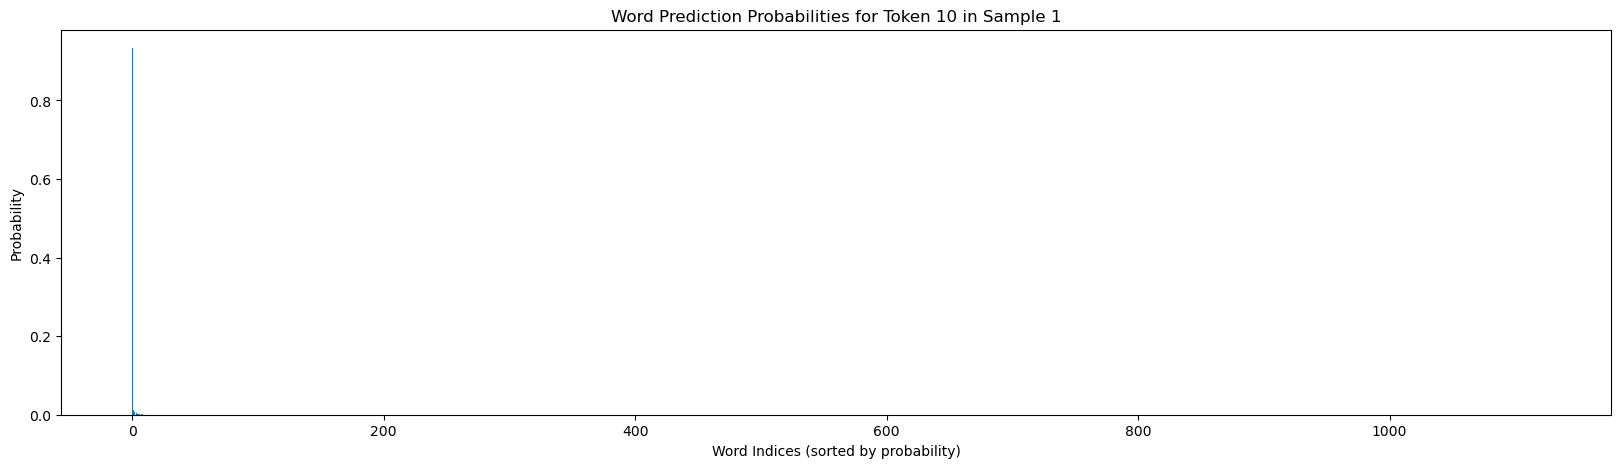

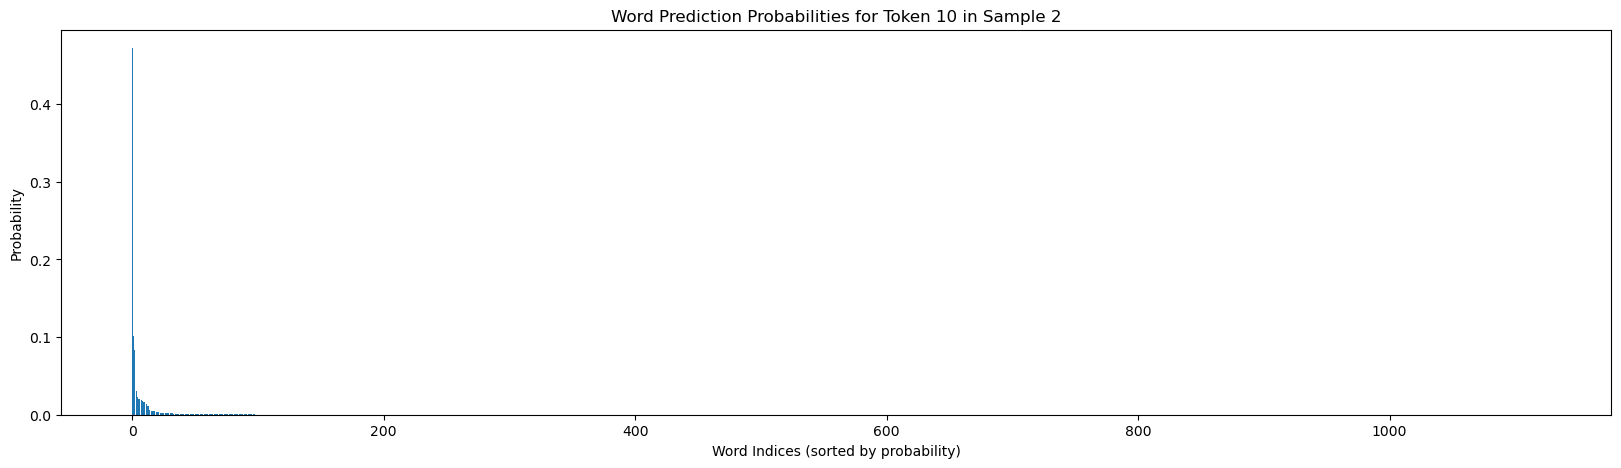

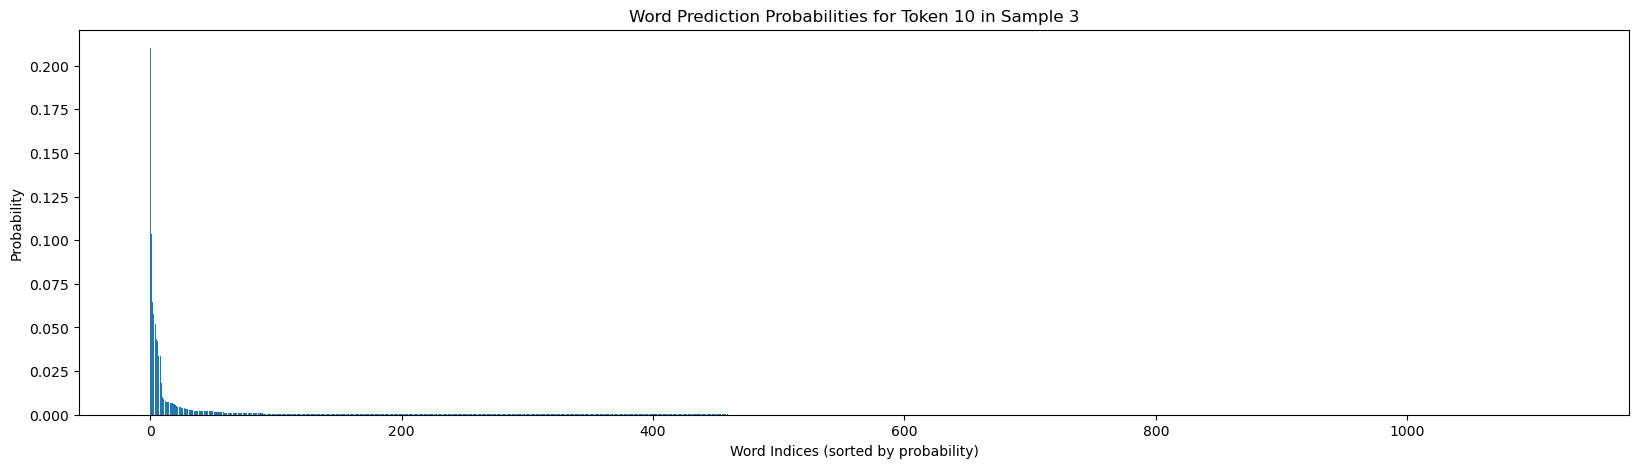

1/1 [==============================] - 0s 198ms/step
Sample 1:
Input sequence [:15]: tf.Tensor(
[  39 1095    5   55   92   16  510  833    1 1096    2  164  146    5
  106], shape=(15,), dtype=int32)
Predicted sequence: [22 20 10 13 11 27 29  7  2  2 23 22 36  9  2  2  5 37  7  2  2 23 54 36
  9  2  2  5 25 36  9  2  2 78 36  9  2  2  2  2  2  2  5 15  3 54  4  5
  5 41]
Predicted text: if a [ i ] == b : 
 
          if += 1 
 
  else : 
 
          count += 1 
 
  x += 1 
 
 break += 1 
 
 
 
 
 
  print ( count )   xxeos 

Sample 2:
Input sequence [:15]: tf.Tensor(
[ 318  384   36  164   27  225 1747 2846  164    6  146 1917   38  270
   47], shape=(15,), dtype=int32)
Predicted sequence: [ 6  3  3 28 26 14 26 13 11  4  2  2 22  3 42 33 27 18 58 68 42 33 27 14
 27 39 42 33 27 18  7  2  2 44 54 36  9  2  2  5  5 15  3 54  4  2  2  5
  5 41]
Predicted text: = ( ( s - n - i ] ) 
 
 if ( % 2 == 0 or min % 2 == n == c % 2 == 0 : 
 
              count += 1 
 
   print ( count ) 
 
   xxeo

In [118]:
# Block 10
# Evaluation Class

class Evaluator:
    def __init__(self, model, loader):
        self.model = model
        self.loader = loader

    def plot_loss(self, history):
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['loss'])
        plt.title('Loss Curve')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.grid(True)
        plt.show()

    def plot_token_probabilities(self, token_index, n_samples=1):
        # Take one batch from the dataset
        for (encoder_input, decoder_input), _ in self.loader.dataset.take(1):
            # Slice the batch down to n_samples
            encoder_input = encoder_input[:n_samples]
            decoder_input = decoder_input[:n_samples]

            # Predict on the sliced inputs
            predictions = self.model.predict([encoder_input, decoder_input])

            for sample_idx in range(n_samples):
                # For each sample, extract token logits and convert to probabilities
                token_logits = predictions[sample_idx, token_index, :]
                token_probabilities = tf.nn.softmax(token_logits).numpy()
                sorted_indices = np.argsort(token_probabilities)[::-1]
                sorted_probabilities = token_probabilities[sorted_indices]

                # Plotting
                plt.figure(figsize=(20, 5))
                plt.bar(range(len(sorted_probabilities)), sorted_probabilities)
                plt.xlabel('Word Indices (sorted by probability)')
                plt.ylabel('Probability')
                plt.title(f'Word Prediction Probabilities for Token {token_index} in Sample {sample_idx+1}')
                plt.show()

    def generate_training_predictions(self, n_samples=1):
        # Take one batch from the dataset
        for (encoder_inputs, decoder_inputs), _ in self.loader.dataset.take(1):
            # Slice the batch down to n_samples
            encoder_inputs = encoder_inputs[:n_samples]
            decoder_inputs = decoder_inputs[:n_samples]

            # Predict on the sliced inputs
            predictions = self.model.predict([encoder_inputs, decoder_inputs])
            predicted_sequences = np.argmax(predictions, axis=-1)

            # Convert sequences to text
            predicted_texts = self.loader.solution_tokenizer.sequences_to_texts(predicted_sequences)
            
            # Print each prediction in the slice
            for i, predicted_text in enumerate(predicted_texts):
                print(f"Sample {i + 1}:") 
                print("Input sequence [:15]:", encoder_inputs[i][:15])
                print("Predicted sequence:", predicted_sequences[i])
                print("Predicted text:", predicted_text, "\n")
    
    def generate_manual_predictions(self, input_text):
        # Tokenize the input string
        input_seq = self.loader.problem_tokenizer.texts_to_sequences([input_text])
        input_padded = tf.keras.preprocessing.sequence.pad_sequences(input_seq, maxlen=self.loader.max_length_input, padding='post')

        # Prepare the decoder input
        start_token_index = self.loader.solution_tokenizer.word_index.get('[START]', 1)  # Fallback to 1 if not found
        decoder_input = np.array([[start_token_index]])
        
        # Generate and interpret the prediction
        predictions = self.model.predict([input_padded, decoder_input])
        predicted_sequence = np.argmax(predictions, axis=-1)[0]
        predicted_text = self.loader.solution_tokenizer.sequences_to_texts([predicted_sequence])
        
        # Print the output
        print("Input text:", input_text)
        print("Predicted text:", predicted_text[0])

    def evaluate(self, command, *args, **kwargs):
        if command == 'loss':
            self.plot_loss(*args, **kwargs)
        elif command == 'token_prob':
            self.plot_token_probabilities(*args, **kwargs)
        elif command == 'training_sample_pred':
            self.generate_training_predictions(*args, **kwargs)
        elif command == 'manual_sample_pred':
            self.generate_manual_predictions(*args, **kwargs)
        else:
            print(f"Unknown command: {command}")

# Load the model if it's not
model = tf.keras.models.load_model('/workspace')

# Uncomment what you want to run
evaluator = Evaluator(model, loader)
#evaluator.evaluate('loss', history)
evaluator.evaluate('token_prob', token_index=10, n_samples=3)
evaluator.evaluate('training_sample_pred', n_samples=3)

input_text = "Print 'hello world'"
evaluator.evaluate('manual_sample_pred', input_text)


In [119]:
%load_ext tensorboard
%tensorboard --logdir logs --host localhost --port 8088

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 8088 (pid 5399), started 1:35:09 ago. (Use '!kill 5399' to kill it.)

In [120]:
#print(len(loader.problem_tokenizer.word_index) + 1)
#print(len(loader.solution_tokenizer.word_index) + 1)

# Clears logs folder
#!find logs -mindepth 1 -delete

#tf.debugging.experimental.disable_dump_debug_info()

#!kill 415

#print("hello")

#print(tf.sysconfig.get_build_info())

#tf.__version__
#!tensorboard --version

#!pip install --upgrade tensorflow
#!pip install --upgrade tensorboard

#f.config.run_functions_eagerly(False)
#f.executing_eagerly()